In [44]:
import gzip
import json
from datetime import datetime

import jsonlines
import pandas as pd

with jsonlines.Reader(gzip.open('../data/politicians_tweetdata_long.jsonl.gz')) as reader:
    raw_politician_tweets = list(reader)


def parse_twitter_datetime(dt: str):
    return datetime.strptime(dt, '%a %b %d %H:%M:%S +0000 %Y')


tweet_df = pd.DataFrame(data={
    'tweet': [t['full_text'] for t in raw_politician_tweets],
    'author': [t['user']['screen_name'] for t in raw_politician_tweets],
    'date': [parse_twitter_datetime(t['created_at']) for t in raw_politician_tweets],
    'id': [t['id'] for t in raw_politician_tweets]
})
tweet_df

,tweet,author,date,id
0,"Madame Vice President, Americans are watching....",MarshaBlackburn,2021-04-22 23:57:20,1385382242751500293
1,"RT @thehill: Sen. @MarshaBlackburn: ""Can you e...",MarshaBlackburn,2021-04-22 23:49:43,1385380324495044613
2,RT @SaraCarterDC: Marsha Blackburn: We need re...,MarshaBlackburn,2021-04-22 23:08:39,1385369992238092288
3,Mainstream media is falling in line with the D...,MarshaBlackburn,2021-04-22 20:43:49,1385333542041784322
4,Democrats want to pack the Supreme Court so th...,MarshaBlackburn,2021-04-22 17:03:59,1385278218186498048
...,...,...,...,...
192759,No authorization for war with Iran:\n• 2001 AU...,justinamash,2020-01-03 16:52:53,1213141191845388288
192760,There’s a reason our Constitution grants Congr...,justinamash,2020-01-03 03:40:45,1212941844558032898
192761,Happy New Year!\n\nMay 2020 be a year of peace...,justinamash,2020-01-01 05:00:00,1212237013040140289
192762,One of the best decisions I made in 2019 was l...,justinamash,2020-01-01 00:25:12,1212167856831508484


Downsample the rows because otherwise there is way too much data

In [2]:
#tweet_df = tweet_df.sample(50000, random_state=0)
#tweet_df

,tweet,author,date,id
76588,"It's hard to believe this has to be said, but ...",JoeBiden,2020-06-04 22:00:00,1268663821998206978
61636,@BernieSanders I understand your support for t...,JoinRocky,2020-01-22 19:27:30,1220065470646108162
53157,I am about to testify before @RulesDemocrats i...,LeaderHoyer,2020-05-14 15:19:19,1260952839851048962
84794,It is my pleasure to join you this Wed Jul 1. ...,DonBeyerVA,2020-06-29 20:10:46,1277696029291405322
102510,MAKE MICHIGAN AND AMERICA GREAT AGAIN! 🇺🇸 http...,Mike_Pence,2020-11-03 07:08:30,1323522425204563969
...,...,...,...,...
135217,The coronavirus (COVID-19) public health emerg...,gracenapolitano,2020-03-25 01:07:31,1242619085680230400
96173,We all have to take steps to make sure that we...,michaelcburgess,2021-01-28 22:37:00,1354921444392710149
25149,"Dems want you to have the 2k, the House GOP do...",RepSchakowsky,2020-12-24 21:41:05,1342223796649005063
64489,(2/2) Durante casi cuatro años he trabajado si...,MarioDB,2021-04-20 18:34:42,1384576271913467911


In [3]:
with open('../data/politicians.json') as file:
    raw_politicians = json.load(file)

politician_handles = [
    {
        'handle': handle['handle'],
        'handle_type': handle['name'],
        'name': p['name'],
        'party': p['party'],
        'lgbt_stance': p['vote_match'][2]
    }
    for p in raw_politicians for handle in p['twitters']
]

politician_df = pd.DataFrame.from_dict(politician_handles)
politician_df = politician_df[politician_df['handle_type'] != 'Don Beyer Twitter feed']
politician_df

,handle,handle_type,name,party,lgbt_stance
0,MarshaBlackburn,Official Twitter,Marsha Blackburn,Republican,0
1,pattymurray,Official Twitter,Patty Murray,Democratic,4
3,PeteSessions,Official Twitter,Pete Sessions,Republican,0
4,SessionsTX17,Campaign Twitter,Pete Sessions,Republican,0
5,KamalaHarris,Campaign Twitter,Kamala Harris,Democratic,4
...,...,...,...,...,...
198,wydenfororegon,Campaign Twitter,Ron Wyden,Democratic,4
199,joesestak,Campaign Twitter,Joe Sestak,Democratic,4
200,amashoffice,Official Twitter,Justin Amash,Libertarian,0
201,teamamash,Campaign Twitter,Justin Amash,Libertarian,0


In [4]:
tweet_df = tweet_df.merge(politician_df, left_on='author', right_on='handle')

In [5]:
import string
import nltk
import numpy as np
from nltk import TweetTokenizer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Build stopword set
stop = set()
stop.update(nltk.corpus.stopwords.words('english'))
stop.update(nltk.corpus.stopwords.words('spanish'))
stop.update(string.punctuation)

# Some twitter-specific ones
stop.update(['rt', '…', '—', 'u'])


def sublist_replacement(original, old, new):
    """Replaces a sublist with another list."""
    output = []

    def is_match(i):
        if len(original) - i < len(old):
            return False
        for j in range(len(old)):
            if original[i + j] != old[j]:
                return False
        return True

    i = 0
    while i < len(original):
        if is_match(i):
            output.extend(new)
            i += len(old)
        else:
            output.append(original[i])
            i += 1

    return output


sublist_replacement(
    ['foo', 'bar', 'spam', 'memes', 'foo', 'bar', 'spam', 'memes'],
    ['bar', 'spam', 'memes'],
    ['eggs', 'ham']
)

[nltk_data] Downloading package stopwords to /home/astrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/astrid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['foo', 'eggs', 'ham', 'foo', 'eggs', 'ham']

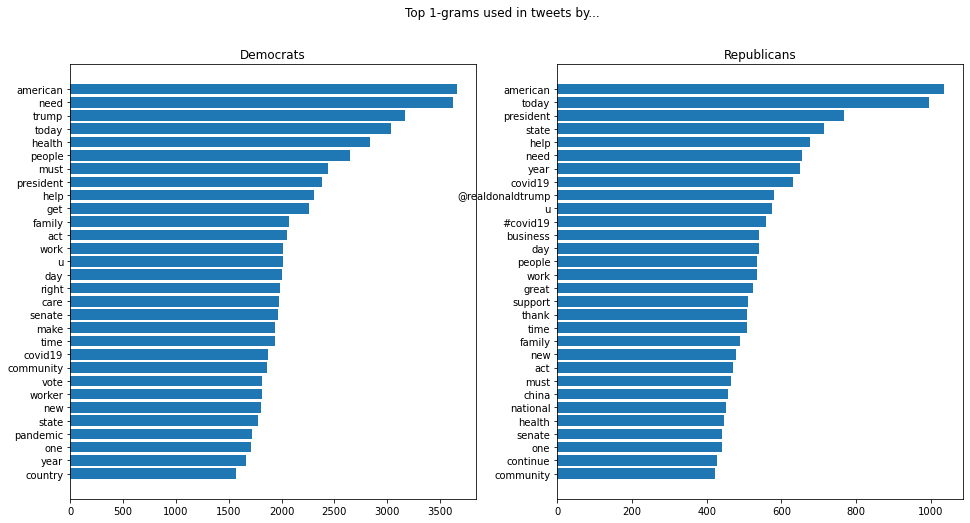

In [6]:
TOKEN_PERMITTED_CHARS = set('#@')


def is_token(token: str, stopwords):
    return all((
        c.isalnum() or c in TOKEN_PERMITTED_CHARS
        for c in token
    )) and token not in stopwords


def clean_tweet_tokens(token_list):
    token_list = sublist_replacement(token_list, ['covid', '-', '19'], ['covid19'])
    token_list = sublist_replacement(token_list, ['covid', '19'], ['covid19'])
    token_list = sublist_replacement(token_list, ['covid'], ['covid19'])
    token_list = sublist_replacement(token_list, ['bears', 'ears'], ['bears ears'])
    return token_list


tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()


def tokenize_tweet(tweet, stopwords):
    tokens = [tok.lower() for tok in tokenizer.tokenize(tweet)]
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in clean_tweet_tokens(tokens)
        if is_token(tok, stopwords)
    ]
    return tokens


def tokenize_tweets(tweets, stopwords):
    return (
        tokenize_tweet(tweet, stopwords)
        for tweet in tweets
    )


def make_ngrams(ngram_size=1):
    def operator(tokens):
        return list(nltk.ngrams(tokens, ngram_size))

    return operator


def tokenize_tweets_and_flatten(tweets, ngram_size=1):
    tokenized_tweets = map(make_ngrams(ngram_size), tokenize_tweets(tweets, stop))
    return (' '.join(ngram) for tweet in tokenized_tweets for ngram in tweet)


def calculate_word_freqs(series, ngram_size=1):
    all_tokens = np.array(list(
        tokenize_tweets_and_flatten(series, ngram_size=ngram_size)
    ))
    tokens, counts = np.unique(all_tokens, return_counts=True)
    frequencies = pd.DataFrame(
        data={'token': tokens, 'count': counts}
    )
    frequencies.set_index('token', inplace=True)
    frequencies.sort_values('count', inplace=True, ascending=False)
    return frequencies


import matplotlib.pyplot as plt


def plot_frequencies(ax: plt.Axes, freq_series):
    top_n = freq_series.iloc[:30]
    ax.barh(top_n.index, top_n)
    ax.invert_yaxis()


def plot_ngrams(ax, tweet_series, ngram_size=1):
    frequency_df = calculate_word_freqs(tweet_series, ngram_size=ngram_size)
    plot_frequencies(ax, frequency_df['count'])


def plot_parties(tweet_df, ngram_size):
    fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(16, 8))

    fig.suptitle(f'Top {ngram_size}-grams used in tweets by...')

    ax_l.set_title('Democrats')
    plot_ngrams(ax_l, tweet_df[tweet_df['party'] == 'Democratic']['tweet'], ngram_size)

    ax_r.set_title('Republicans')
    plot_ngrams(ax_r, tweet_df[tweet_df['party'] == 'Republican']['tweet'], ngram_size)


plot_parties(tweet_df, 1)
plt.show()

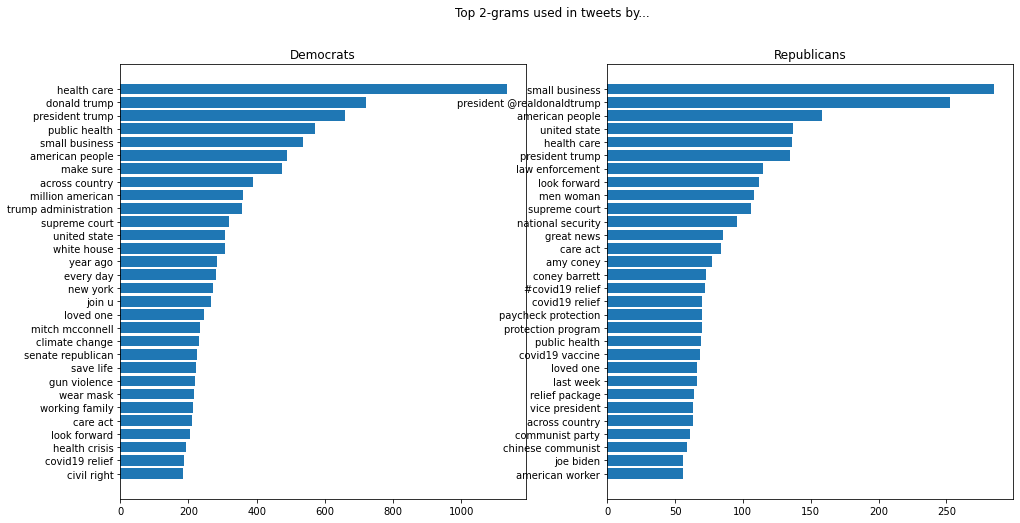

In [7]:
plot_parties(tweet_df, 2)
plt.show()

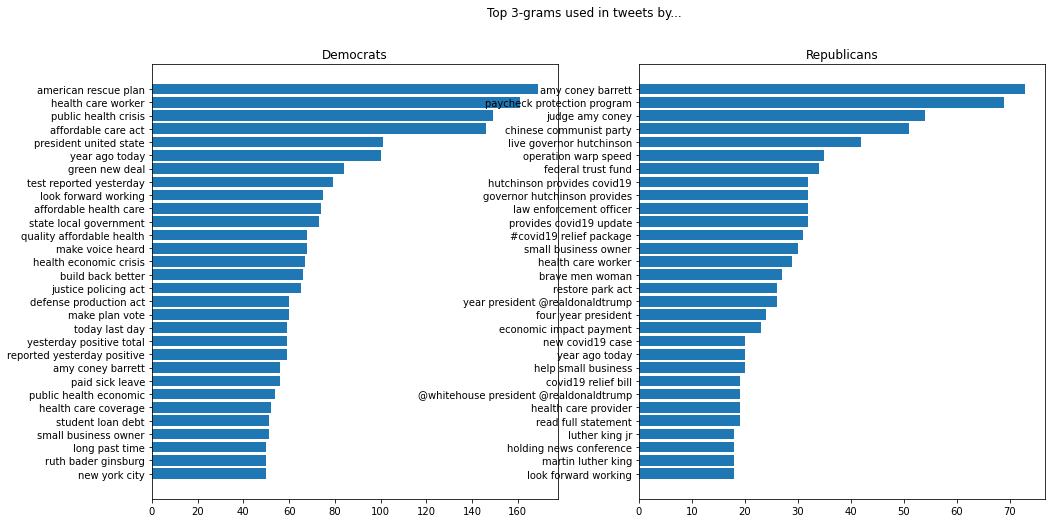

In [8]:
plot_parties(tweet_df, 3)
plt.show()

LGBT specifically

In [45]:
ngrams = calculate_word_freqs(tweet_df['tweet'], ngram_size=1)
ngrams2 = calculate_word_freqs(tweet_df['tweet'], ngram_size=2)

In [58]:
pd.set_option('display.max_rows', 50)
ngrams.loc[[x for x in ngrams.index if 'trans' in x or 'lgbt' in x or 'bisexual' in x or 'lesbian' in x or 'homo' in x or 'gay' in x]]

,count
token,
lgbtq,745
transparency,666
transportation,651
@transportdems,412
transition,391
...,...
@transparencyusa,1
@transpochoices,1
@transportde,1


In [51]:
import gensim
ranged_df = tweet_df
documents = list(tokenize_tweets(ranged_df['tweet'], stop))
dictionary = gensim.corpora.Dictionary(documents)

In [52]:
from gensim import corpora, models
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [85]:
TOPICS = 50
lda_model_tfidf = models.LdaMulticore(corpus_tfidf, num_topics=TOPICS, id2word=dictionary, passes=50, workers=8)

In [86]:
for idx, topic in lda_model_tfidf.print_topics(-1, num_words=15):
    print('{}\t{}'.format(idx, topic))

0	0.065*"life" + 0.062*"republican" + 0.051*"nation" + 0.046*"fighting" + 0.038*"honor" + 0.036*"law" + 0.029*"history" + 0.027*"sign" + 0.026*"bring" + 0.026*"never" + 0.025*"year" + 0.024*"expand" + 0.024*"american" + 0.024*"already" + 0.022*"violence"
1	0.000*"congra" + 0.000*"bong" + 0.000*"@emnewsdc" + 0.000*"premiered" + 0.000*"#partyoffive" + 0.000*"varsity" + 0.000*"@stjohnboscohs" + 0.000*"joon" + 0.000*"#az02" + 0.000*"resolv" + 0.000*"#demsatthebo" + 0.000*"asyl" + 0.000*"#goldenglobes" + 0.000*"policie" + 0.000*"#protectolderworkers"
2	0.000*"congra" + 0.000*"bong" + 0.000*"@emnewsdc" + 0.000*"premiered" + 0.000*"#partyoffive" + 0.000*"varsity" + 0.000*"@stjohnboscohs" + 0.000*"joon" + 0.000*"#az02" + 0.000*"resolv" + 0.000*"#demsatthebo" + 0.000*"asyl" + 0.000*"#goldenglobes" + 0.000*"policie" + 0.000*"#protectolderworkers"
3	0.150*"important" + 0.089*"without" + 0.057*"healthcare" + 0.049*"data" + 0.043*"#2020census" + 0.041*"begin" + 0.035*"really" + 0.034*"count" + 0.03

In [82]:
trans_tweets = tweet_df[tweet_df['tweet'].str.lower().str.find('transgender') > 0]
trans_tweets

,tweet,author,date,id
3488,I'm so proud of Tacoma's Stella Keating for sp...,PattyMurray,2021-03-17 19:51:45,1372274474788196367
3590,Republicans introduced an amendment that was s...,PattyMurray,2021-03-06 14:57:24,1368214135612248067
3801,.@teachcardona is exactly right. As I said tod...,PattyMurray,2021-02-03 19:05:10,1357042463316336645
3866,Former President Trump's ban on transgender se...,PattyMurray,2021-01-25 19:29:13,1353787023690256395
4146,"Today on #TransDayOfRemembrance, we honor the ...",PattyMurray,2020-11-20 18:00:43,1329847151879458817
...,...,...,...,...
188397,Proud this #TransgenderAwarenessWeek and every...,RonWyden,2020-11-19 21:15:23,1329533755598389248
190292,@WillFiteForYou @AnonymousStaffr I’m not sure ...,justinamash,2021-01-25 21:32:38,1353818083908059137
190294,@WillFiteForYou @AnonymousStaffr As you can se...,justinamash,2021-01-25 21:15:58,1353813887922147328
190298,This is a win for equality before the law. Tra...,justinamash,2021-01-25 16:42:49,1353745147398393858


Sum of scores

In [83]:
bows = [bow_corpus[i] for i in trans_tweets.index]
topic_scores = [0 for _ in range(TOPICS)]

for tweet_topics in lda_model_tfidf[bows]:
    for idx, score in tweet_topics:
        topic_scores[idx] += score
list(sorted(enumerate(topic_scores), key=lambda pair: pair[1]))

[(4, 0.03999999910593033),
 (8, 0.03999999910593033),
 (9, 0.03999999910593033),
 (15, 0.03999999910593033),
 (19, 0.03999999910593033),
 (20, 0.03999999910593033),
 (22, 0.03999999910593033),
 (23, 0.03999999910593033),
 (25, 0.03999999910593033),
 (26, 0.03999999910593033),
 (27, 0.03999999910593033),
 (28, 0.03999999910593033),
 (29, 0.03999999910593033),
 (32, 0.03999999910593033),
 (34, 0.03999999910593033),
 (38, 0.03999999910593033),
 (39, 0.03999999910593033),
 (44, 0.03999999910593033),
 (45, 0.03999999910593033),
 (47, 0.03999999910593033),
 (48, 0.03999999910593033),
 (7, 0.2997782900929451),
 (16, 0.43363967537879944),
 (24, 0.4564238376915455),
 (11, 0.7093305811285973),
 (42, 0.758843407034874),
 (31, 0.8805377408862114),
 (36, 0.911752812564373),
 (1, 1.2072904780507088),
 (49, 1.7896298319101334),
 (14, 2.0366812273859978),
 (5, 2.3572740629315376),
 (37, 2.4420587308704853),
 (17, 2.5377258136868477),
 (6, 2.774760290980339),
 (2, 3.0908347219228745),
 (10, 3.657112706

Count of maximum topic scores

In [84]:
bows = [bow_corpus[i] for i in trans_tweets.index]
topic_counts = [0 for _ in range(TOPICS)]

for tweet_topics in lda_model_tfidf[bows]:
    idx, score = max(tweet_topics, key=lambda pair: pair[1])
    topic_counts[idx] += 1
list(sorted(enumerate(topic_counts), key=lambda pair: pair[1]))

[(1, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (11, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (19, 0),
 (20, 0),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (31, 0),
 (32, 0),
 (34, 0),
 (36, 0),
 (38, 0),
 (39, 0),
 (42, 0),
 (44, 0),
 (45, 0),
 (47, 0),
 (48, 0),
 (49, 0),
 (10, 1),
 (17, 1),
 (37, 1),
 (3, 2),
 (12, 2),
 (35, 3),
 (41, 3),
 (40, 4),
 (2, 5),
 (13, 5),
 (33, 5),
 (21, 6),
 (43, 10),
 (18, 13),
 (46, 35),
 (30, 50),
 (0, 61)]